<a href="https://colab.research.google.com/github/jb-chaudron/inet-vanilla/blob/main/Network%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Installation des paquets

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 3.4MB/s 


In [ ]:
pip install mne

     |████████████████████████████████| 6.9MB 6.2MB/s 


In [ ]:
pip install permute

     |████████████████████████████████| 163kB 5.9MB/s 
     |████████████████████████████████| 27.4MB 119kB/s 
     |████████████████████████████████| 15.3MB 325kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: jaxlib 0.1.60+cuda101 has requirement numpy<1.20,>=1.12, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp37-none-any.whl size=24787 sha256=d3e89b0f3abe5a793d03068f96f51a7fd8aad31ac5ac53213c1142b06b789ba4
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [ ]:
pip install cdlib

     |████████████████████████████████| 143kB 5.1MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 40.6MB 92kB/s 
     |████████████████████████████████| 1.8MB 48.1MB/s 
     |████████████████████████████████| 24.2MB 70.0MB/s 
  Created wheel for karateclub: filename=karateclub-1.0.23-cp37-none-any.whl size=94180 sha256=178eee69c21c0771e77da41da1240086fe0edae0ecdaab0c433f0e34cecb20b8
  Stored in directory: /root/.cache/pip/wheels/99/32/73/eb3cd782b42b2391903746fa053b373d4bc501ad66c3da49ae
  Created wheel for python-louvain: filename=python_louvain-0.14-cp37-none-any.whl size=9292 sha256=9af3c89a28d4d5fdffdabb17ac33156f7e7591714c0bd05a9c98201eb52237c2
  Stored in directory: /root/.cache/pip/wheels/e7/8d/24/6b3a464bb23e96ecba3f68868e85721534fd8158a9cd7b426b
Successfully built karateclub python-louvain
  Found existing installation: python-louvain 0.15
    Uninstalling python-louvain-0.15:
      Successfully uninstalled python-louvain-0.15

In [ ]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import scipy.stats as sts
import random
from statsmodels.stats.multitest import multipletests
import math
from skopt import BayesSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install EMD-signal

     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 71kB 4.4MB/s 


In [ ]:
pip install cdlib

#2 - Preprocessing / Graph

#2.a - Ouverture du jeu de données

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Patient/epoch_p01_bipolaire_clean-epo.fif"

ep = mne.read_epochs(path)


Reading /content/drive/My Drive/Colab Notebooks/Patient/epoch_p01_bipolaire_clean-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
Replacing existing metadata with 22 columns
498 matching events found
No baseline correction applied
0 projection items activated


#2.b - Potentiels évoqués -  FDR Graph 

Cette section produit deux graphs, en se basant sur les p-value corrigées des correlations entre les noeuds

La section est organisée comme suit


1.   Définition des fonctions qui produisent les graphs
2.   "Pipeline"



1. Fonctions

In [ ]:
#Découpe le signal en bande de 10Hz, le normalise bande par bande et l'additionne pour ne faire qu'un seul signal
def hilb_10hz(lf,hf,data):
  for i in range(lf,hf,10):
    j = i + 10
    if i == 10:
      i = 15
    else:
      pass

    n_dat = data.copy().filter(l_freq=i,h_freq=j,n_jobs=1,fir_design='firwin')#Récupère le signal sur la première bande de 10Hz
    n_dat.apply_hilbert(n_jobs=1,envelope=True)#Récupère l'enveloppe du signal pour cette fréquence là
    
    if j == lf+10:
      #1er condition pour initialiser l'output
      out = n_dat.to_data_frame(index='time')
      out = out.apply(sts.zscore,axis=0)#Normalise le signal de chaque contact (colonne par colonne) 
      
    else:
      dat = n_dat.to_data_frame(index="time")
      dat = dat.apply(sts.zscore,axis=0)
      out = out + dat #Additionne le signal normalisé de chaque contact, ms par ms
      
      del dat
    del n_dat
  return out #Retourne le signal normalisé

In [ ]:
#Produit le Graph en se basant sur la correlation entre les signaux des contacts
def graph(df,graph=1):
  """
    Premier bloc : Génère les variables qui vont être remplies ensuite
      - Les colonnes du DataFrame sont les contacts, les lignes sont les millisecondes
      - Le graph a "n" noeuds, qui sont les "n" contacts/colonnes
      - La variable "pval" va prendre la p-value de la correlation entre deux noeuds, d'où sa dimension (n,n) avec n le nombre de contacts
  """
  G = nx.Graph()
  sig = {a : {} for a in df.columns}
  G.add_nodes_from(df.columns)
  pval = np.empty((len(df.columns),len(df.columns)),dtype=object)
  c = 0
  
  """
    Deuxième partie 
      - On attribue à chaque couple de contact une p-value en utilisant le r de spearman
      - Ensuite on corrige les p-value avec la méthode de Holm, avec un seuil alpha < 0.01
  """
  for i in df.columns:
    #Récupère la correlation de spearman entre les contacts et la p-value de cette correlation
    sig[i] = {x : sts.spearmanr(df[i],df[x]) for x in df.columns}
    pval[c,:] = [sig[i][x][1] for x in sig[i].keys()]#Stock les p-values
    c+=1
  
  pval = np.reshape(pval,(len(df.columns)*(len(df.columns))))#On applatie l'array pour que toutes les p-values soient corrigées ensembles
  a = multipletests(pval,alpha=0.01,method='holm')#Correction des p-values
  b = np.reshape(a[0],(len(df.columns),len(df.columns)))#On désapplatie l'array pour attribuer la p-value correspondante à chaque liens
  

  """
    Troisième partie
      - Condition (graph == 1) 
        -- On utilise le vecteur booléen rejetant les couples ayant des correlations non significatives
        -- On ajoute, dans le graph, un lien entre les noeuds significativement corrélés 
      - Condition 2
        -- On retourne les p-values corrigées
  """
  #Condition de base
  if graph == 1:
   
    for i in range(len(df.columns)):
      #Ajoute tous les contacts pour lesquels le contact "i" a la p-value de sa correlation corrigée < 0.01 
      add = [df.columns[x] for x in range(len(df.columns)) if b[i][x]]
      
      if len(add) == 0:
        pass
      else:
        #Ajoute dans le graph un lien non dirigé entre les noeuds significativements lié
        #et attribus un poids à leur lien (la valeur absolue de la correlation des signaux)
        G.add_edges_from([(df.columns[i],x,{"weight" :abs(sig[df.columns[i]][x][0])}) for x in add if not df.columns[i]==x])
    return G

  #Condition pour le NBS car on veut comparer les statistiques produites ici avec celle des permutations
  else:
    return np.reshape(a[1],(len(df.columns),len(df.columns))),sig

2. Pipeline

In [ ]:
#Récupère le potentiel évoqué des épochs réussies et échouées pour une bande temporelle données

ep_succ = ep["error == 1.0"].copy().average()
ep_err = ep["error == 0.0"].copy().average()

In [ ]:
#Transformation du signal en densité spectrale moyennée sur bande de 10Hz
ep_succ = ep_succ.crop(tmin=0.0,tmax=0.4).filter(l_freq=80,h_freq=120).apply_hilbert(envelope=True).crop(tmin=0.3,tmax=0.4).to_data_frame(index="time")
ep_err = ep_err.crop(tmin=0.0,tmax=0.4).filter(l_freq=80,h_freq=120).apply_hilbert(envelope=True).crop(tmin=0.3,tmax=0.4).to_data_frame(index="time")

Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 169 samples (0.165 sec)

Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff fr

In [ ]:
#Production des graphs associés
g_err = graph(ep_err)
g_succ = graph(ep_succ)

#2.c Network Based Statistic Graph

La statistique basé sur le réseau prend en compte la probabilité d'un lien entre deux noeuds lors de permutations pour déterminer la significativité du lien (cf. Zalesky, Fornito & Bullmore; 2010).

Ça nous permet d'avoir deux réseaux (un pour les érreurs et un pour les réussites) qui devraient refléter la connectivité spécifique à la réussite de la tâche et celle spécifique à l'échec de la tâche

La section est organisée comme suit 


1.   Fonctions utilisées plus tard pour la NBS (Network Based Statistic)
2.   Variantes de la NBS (qu'on pourrait unifier) qui utilisent ou bien la p-value ou bien la valeur de la correlation comme statistique de base
3.   "Pipeline" qui éxecute les fonctions dans l'ordre pour produire les graphs d'intérêt



1. Fonctions

In [ ]:
#Découpe les données en bandes de 10Hz puis les moyennes
def hilbraw_10hz(lf,hf,data):

  for i in range(lf,hf,10):
    j = i + 10
    if i == 10:
      i = 15
    else:
      pass
    n_dat = data.copy().filter(l_freq=i,h_freq=j,n_jobs=1,fir_design='firwin')
    n_dat.apply_hilbert(n_jobs=1,envelope=True)
    if j == lf+10:
      out = n_dat.get_data()
      out = sts.zscore(out,axis=2)

    else:
      dat = n_dat.get_data()
      dat = sts.zscore(dat,axis=2)
      out = out+dat

      del dat
    del n_dat
  return out

In [ ]:
#Pour produire une permutation des signaux
def perm(d1,d2,l=100):
  m1 = random.choices(range(np.shape(d1)[0]),k=l)
  m2 = random.choices(range(np.shape(d2)[0]),k=l)
  m3 = np.concatenate((d1[m1,:,:],d2[m2,:,:]),axis=0)
  m3 = np.mean(m3,axis=0) #shape(n_contact,n_ms)
  print(np.shape(m3))
  return m3

2. Deux version du NBS, l'une prenant en compte les p-values corrigées, l'autre la corrélation

In [ ]:
def NBS(d1,d2,con,df1,df2,k=100):
  pper = np.empty((len(con),len(con),k),dtype=np.float64)
  
  #Boucle sur k : Le nombre de permutation que l'on veut faire
  for j in range(k):
    #Initialisation des variables qu'on va utiliser
    per = perm(d1,d2,100)
    sig = {a : {} for a in con}
    pval = np.empty((len(con),len(con)),dtype=object)
    c = 0

    #Boucle sur la taille de la première dimension de l'array "per", càd le nombre de contacts
    for i in range(np.shape(per)[0]):
      #Récupère la p-value entre le signal de deux noeuds pour cette permutation
      sig[con[i]] = {con[x] : sts.spearmanr(per[i],per[x]) for x in range(len(con))}
      pval[c,:] = [sig[con[i]][x][1] for x in sig[con[i]].keys()]
      c+=1
    
    #Procédure de tests multiples pour la correction des p-values
    pval = np.reshape(pval,(len(con)*(len(con))))
    a = multipletests(pval,alpha=0.01,method='holm')
    pper[:,:,j] = np.reshape(a[1],(len(con),len(con)))
    print(j)
  
  ###%Création du graph N°1, erreur ou réussite
  g1,sig1 = graph(df1,graph=0) #shape(n_contact,n_contact)
  G1 = nx.Graph()
  #Ajoute un lien entre deux contacts si leur p-value est inférieur à 95% de celles obtenues
  for i in range(len(con)):
    print([np.sort(pper[i,x,:])[math.ceil(0.05*k)] for x in range(len(con))])
    add = [con[x] for x in range(len(con)) if g1[i][x] < np.sort(pper[i,x,:])[math.ceil(0.05*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig[con[i]][x][0])}) for x in add if not con[i]==x])
  
  ###% Création du graph N°2, réussite ou erreur
  g2,sig2 = graph(df2,graph=0)
  G2 = nx.Graph()
  for i in range(len(con)):
    #print("G2 = ",g2[1][1])
    #print("pval = ",np.sort(pper[1,1,:])[math.ceil(0.05*k)])
    add = [con[x] for x in range(len(con)) if g2[i][x] < np.sort(pper[i,x,:])[math.ceil(0.05*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig[con[i]][x][0])}) for x in add if not con[i]==x])
  
  #Retourne les deux graphs
  return G1,G2

In [ ]:
def NBSS(d1,d2,con,df1,df2,k=100):
  pper = np.empty((len(con),len(con),k),dtype=np.float64)
  
  #%%%% On calcul les statistiques des différentes permutations
  for j in range(k):
    #1) On fait une permutation
    per = perm(d1,d2,100)

    #2) On construit un dictionnaire pour y inclure les résultats de spearman
    sig = {a : {} for a in con}
    pval = np.empty((len(con),len(con)),dtype=object) #Artéfact des différentes forme, à rejeter si pas besoin
    c = 0

    #3) Pour chaque contact, on attribue un score de corrélation pour cette permutation
    pper[:,:,j] = np.absolute(sts.spearmanr(per,axis=1)[0])
    """
    for i in range(np.shape(per)[0]):
      sig[con[i]] = {con[x] : sts.spearmanr(per[i],per[x]) for x in range(len(con))}
      pper[c,:,j] = [abs(sig[con[i]][x][0]) for x in sig[con[i]].keys()]
      c+=1
    """
  #%%%% On calcul la NBS pour le graph de la condition 1
  #1) On calcul la correlation de spearman pour les données du graph 1
  g1,sig1 = graph(df1,graph=0) #shape(n_contact,n_contact)
  G1 = nx.Graph()

  #2) On compare la force de la correlation à celle des permutations
  for i in range(len(con)):
    add = [con[x] for x in range(len(con)) if abs(sig1[con[i]][con[x]][0]) > np.sort(pper[i,x,:])[math.floor(0.95*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig1[con[i]][x][0])}) for x in add if not con[i]==x])

  #%%%% On calcul la NBS pour le graph de la condition 2
  g2,sig2 = graph(df2,graph=0)
  G2 = nx.Graph()
  for i in range(len(con)):
    add = [con[x] for x in range(len(con)) if abs(sig2[con[i]][con[x]][0]) > np.sort(pper[i,x,:])[math.floor(0.95*k)]]
    if len(add) == 0:
      pass
    else:
      G2.add_edges_from([(con[i],x,{"weight" :abs(sig2[con[i]][x][0])}) for x in add if not con[i]==x])
  cut = np.array([[np.sort(pper[i,x,:])[math.floor(0.95*k)] for i in range(len(con))]for x in range(len(con))])
  return G1,G2,cut

3. "Pipeline"

In [ ]:
#Récupère le signal non moyenné cette fois (càd par le potentiel évoqué)
epraw_succ = ep["error == 1.0"].copy()
epraw_err = ep["error == 0.0"].copy()

In [ ]:
#Récupère l'enveloppe du signal
epraw_succ = sts.zscore(epraw_succ.crop(tmin=0.0,tmax=0.4).filter(l_freq=80,h_freq=120).apply_hilbert(envelope=True).crop(tmin=0.3,tmax=0.4).get_data(),axis=2)
epraw_err = sts.zscore(epraw_err.crop(tmin=0.0,tmax=0.4).filter(l_freq=80,h_freq=120).apply_hilbert(envelope=True).crop(tmin=0.3,tmax=0.4).get_data(),axis=2)
#epraw_succ = hilbraw_10hz(80,120,epraw_succ)
#epraw_err = hilbraw_10hz(80,120,epraw_err)

Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 169 samples (0.165 sec)

Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff fr

In [ ]:
#Produit les graphs et récupère la liste des statistiques seuil pour chaque paires de contacts
nbg_err,nbg_succ,cutoff = NBSS(epraw_err,epraw_succ,ep.info["ch_names"],ep_err,ep_succ,k=20)

(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)


#3 Analyse des graphs (Pas tout à fait fini)

#3.a - Description des Graphs

Différentes métriques pour décrire les graphs de façon basique

Nb Noeuds +
Nb Liens

In [ ]:
def desc_taille(graph):
  for c in nx.connected_components(graph):
    print("Nb noeuds = ",len(graph.subgraph(c).number_of_nodes()))
    print("Nb liens = ",len(graph.subgraph(c).number_of_edges()))

Clustering Coefficient + Densité

In [ ]:
def desc_cc_dens(graph,w=False):
  for c in nx.connected_components(graph):
    if w:  
      print("Clustering Coefficient : ",nx.clustering(graph.subgraph(c),weight="weight"))
    else:
      print("Clustering Coefficient : ",nx.clustering(graph.subgraph(c)))
    print("Densité : ",nx.density(c))

Av Path Length + Diamètre

In [ ]:
def desc_pl_diam(graph,w=False):
  for c in nx.connected_components(graph):
    if w:
      print("Average path length : ",nx.average_shortest_path_lentgh(c,weight="weight"))
      print("Diamètre : ",nx.diameter(c,weight="weight"))
    else:
      print("Average path length : ",nx.average_shortest_path_lentgh(c))
      print("Diamètre : ",nx.diameter(c))

[40, 44, 63, 54, 40, 42, 62, 12, 46, 24, 37, 41, 53, 35, 32, 43, 23, 39, 43, 50, 41, 51, 30, 47, 48, 49, 36, 61, 57, 42, 53, 48, 31, 57, 34, 47, 32, 47, 59, 48, 30, 32, 37, 61, 43, 44, 30, 25, 28, 28, 39, 53, 47, 27, 51, 45, 46, 32, 28, 37, 39, 54, 49, 31, 32, 19, 57, 31, 29, 53, 38, 47, 38, 42, 37, 48, 44, 31, 20, 43, 53, 44, 36, 38, 33, 51, 27, 30, 15, 40, 44, 38, 24, 61, 52, 47, 34, 46, 45, 28, 31, 44, 52, 37, 44, 38, 46, 37, 54, 43, 36, 47, 42, 35, 48, 33, 53, 45, 44, 52, 42, 45]


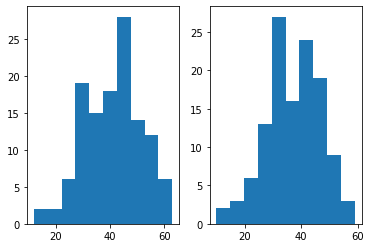

42.0
38.0


'\nprint([x for x in g_err.nodes])\nprint(nx.average_clustering(g_err))\nprint(nx.average_clustering(g_succ))\nfor C in nx.connected_components(g_succ):\n    print(len(C))\n\n\n\nprint(nx.average_shortest_path_length(g_err,weight="weight"))\nprint(nx.average_shortest_path_length(g_err,weight=None))\nprint(nx.average_shortest_path_length(g_succ,weight="weight"))\nprint(nx.average_shortest_path_length(g_succ,weight=None))\n'

In [ ]:
import scipy.stats as sts
e_deg = [x[1] for x in g_err.degree]
s_deg = [x[1] for x in g_succ.degree]
print(e_deg)
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.hist(e_deg)
ax2.hist(s_deg)
plt.show()
print(np.median(e_deg))
print(np.median(s_deg))
"""
print([x for x in g_err.nodes])
print(nx.average_clustering(g_err))
print(nx.average_clustering(g_succ))
for C in nx.connected_components(g_succ):
    print(len(C))



print(nx.average_shortest_path_length(g_err,weight="weight"))
print(nx.average_shortest_path_length(g_err,weight=None))
print(nx.average_shortest_path_length(g_succ,weight="weight"))
print(nx.average_shortest_path_length(g_succ,weight=None))
"""

In [ ]:
bt = nx.pagerank(g_err,weight='weight')
nx.set_node_attributes(g_err,bt,"rank")
h_bt_err = sorted(bt.keys(),key=lambda x: bt[x],reverse=True)[:20]
l_bt_err = sorted(bt.keys(),key=lambda x: bt[x])[:20]

print(h_bt_err[:20])
print(l_bt_err[:20])

["tp'6-tp'7", "ip'13-ip'14", "tb'4-tb'5", "t'7-t'8", "b'10-b'11", "h'5-h'6", "of'6-of'7", "b'11-b'12", "gph'7-gph'8", "or'4-or'5", "tb'10-tb'11", 'h1-h2', "tp'7-tp'8", 'b2-b3', "of'9-of'10", "of'1-of'2", 'b10-b11', "pi'14-pi'15", "pi'1-pi'2", "b'4-b'5"]
["tb'5-tb'6", "ip'3-ip'4", "ia'5-ia'6", "of'5-of'6", "a'4-a'5", "ip'12-ip'13", "h'11-h'12", "or'6-or'7", "ip'1-ip'2", "or'2-or'3", "or'11-or'12", "of'8-of'9", "tb'7-tb'8", "b'5-b'6", "or'1-or'2", "h'10-h'11", "h'2-h'3", "pi'11-pi'12", "of'4-of'5", "of'7-of'8"]


In [ ]:
bt = nx.pagerank(g_succ,weight='weight')
nx.set_node_attributes(g_succ,bt,"rank")
h_bt_succ = sorted(bt.keys(),key=lambda x: bt[x],reverse=True)[:20]
l_bt_succ = sorted(bt.keys(),key=lambda x: bt[x])[:20]

print(h_bt_succ[:20])
print(l_bt_succ[:20])

diff_h = set(h_bt_succ).intersection(set(h_bt_err))
diff_l = set(l_bt_err).intersection(set(l_bt_err))

print(diff_h)
print(diff_l)

["gph'9-gph'10", "a'7-a'8", "b'6-b'7", "ip'5-ip'6", "pi'9-pi'10", "b'5-b'6", "tp'1-tp'2", "ia'10-ia'11", "pi'10-pi'11", 'b11-b12', 'tb9-tb10', "ip'4-ip'5", "or'13-or'14", "t'2-t'3", "t'7-t'8", 'tb1-tb2', "pi'12-pi'13", 'b8-b9', "tb'7-tb'8", "or'9-or'10"]
["pi'13-pi'14", 'b5-b6', "b'12-b'13", "t'1-t'2", 'b2-b3', "of'9-of'10", "of'4-of'5", "tp'5-tp'6", "ia'2-ia'3", "tb'8-tb'9", 'b4-b5', 'h8-h9', "ip'12-ip'13", "or'2-or'3", "tb'5-tb'6", "b'7-b'8", "tb'6-tb'7", "h'4-h'5", "ip'11-ip'12", "gph'6-gph'7"]
{"t'7-t'8"}
{"ip'3-ip'4", "ip'1-ip'2", "of'5-of'6", "or'6-or'7", "ip'12-ip'13", "of'7-of'8", "or'1-or'2", "pi'11-pi'12", "b'5-b'6", "tb'5-tb'6", "of'4-of'5", "a'4-a'5", "h'10-h'11", "or'11-or'12", "or'2-or'3", "of'8-of'9", "h'2-h'3", "ia'5-ia'6", "tb'7-tb'8", "h'11-h'12"}


#3.b Centralité /!\ Ne pas lancer pour l'instant

/!\ Il ne faut pas lancer cette section pour l'instant
Analyse de la centralité des noeuds 

Betweenness

In [ ]:
ct = nx.betweenness_centrality()

TypeError: ignored

Harmonic Centrality

In [ ]:
ct = nx.harmonic_centrality()

TypeError: ignored

Katz

In [ ]:
ct = nx.katz_centrality()

PageRank

In [ ]:
ct = nx.pagerank()

Jaccard Coefficient des X meilleurs ou plus mauvais noeud selon les métriques

In [ ]:
def jaccard(G,func,w=False,n=20,bout="h"):
  """
    G : Une liste de graphs
    func : La fonction de centralité que l'on souhaite utiliser
    w : Les liens sont pondérés ou non
    n : Le nombre de noeuds que l'on veut considéré pour voir s'il y a une différence entre les réseaux
    bout : Est ce qu'on veut les "n" noeuds avec la plus petite "b" ou plus grande centralité "h" ?
  """

  #On détermine les noms des composants que l'on va comparer
  #Le premier graph s'appellera G1_s1, si il a plusieurs sous graph il aura d'autres noms G1_s2, G1_s3 etc...
  #Les autres graphs seront G2_s1,G3_s1 etc... avec s2, s3 etc... si il y a des sous composants chez eux aussi
  lab = reduce(lambda a,b: a+b,[["G"+str(i+1)+"_s"+str(j+1) for j in range(len(nx.connected_components(G[i])))] for i in range(len(G))])
  df = pd.DataFrame(index=lab,columns=lab)

  #On détermine si on triera dans l'ordre ascendant ou descendant
  if bout == "h":
    bout = True
  else:
    bout = False

  ct = []
  d = 0
  for i in G:
    for c in nx.connected_components(i):
      if w:
        central = func(i.subgraph(c),weight="weight")
      else:
        central = func(i.subgraph(c))
      ct[d] += [set(sorted(central.keys(),reverse=bout,key=lambda a: central[a])[:n])]
      d += 1

  for i,j in itr.product(range(len(ct)),range(len(ct))):
    df.iloc[i,j] = len(ct[i].intersection(ct[j]))/len(ct[i].union(ct[j]))
  return df

#3.c - Random Network / Power Law / Degree distribution

Cette section fit la distribution des noeuds selon une "power law" et vise à décrire les différences entre les graphs à partir de là



Degree Distribution

In [ ]:
def deg(G):
  d = [x[1] for x in G.degree]
  plt.hist(d)
  plt.show()

Power Law

In [ ]:
import powerlaw
def PL(G):
  data = [x[1] for x in G.degree]
  results = powerlaw.Fit(data)
  print("Alpha = ",results.power_law.alpha)
  print("Xmin = ",results.power_law.xmin)
  R, p = results.distribution_compare('power_law', 'lognormal')

  print("p_val Kolmogorov = ",results.power_law.KS(data))
  return results

In [ ]:
a = PL(nbg_err)

Alpha =  4.55716315791209
Xmin =  6.0
p_val Kolmogorov =  0.10209114846342121


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [ ]:
#On peut évaluer à quel point une distribution d'un graph fit avec les données d'un autre
#p.ex.
f_err = PL(g_err)
f_succ = PL(g_succ)
#Test pour savoir à quel point la distribution des degrés du réseau des succès décrit la distribution des dégrés des erreurs
print("KS succ -> err = ",f_succ.power_law.KS([x[1] for x in g_err.degree]))

Alpha =  8.93135971114567
Xmin =  44.0
p_val Kolmogorov =  0.12629270996716768
Alpha =  49.85873662740003
Xmin =  54.0
p_val Kolmogorov =  0.12964484355853267
KS succ -> err =  0.12964484355853267


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


#3.d Détection de Communautés

Cette section vise à comparer les communautées obtenues par les différents graphs pour voir si ils possèdent les mêmes

Classique Louvain

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters

In [ ]:
def lou(G,pos):
  louv_clust = louvain(G,weight='weight')

  ## 1.c : Noter les communautés sur le graph de base
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(G,com,"community")

  ## 1.d : Visualiser les communautées
  #pos = nx.drawing.layout.spring_layout(g_err)
  plot_network_clusters(G, louv_clust, pos,figsize=(15,15))
  plt.show()
  #plt.savefig("comm_graph",dpi=300)

In [ ]:
def prepro_csv(chemin,ch_names):
  #1 Ouverture et standardisation du fichier
  df_con = pd.read_csv(chemin)
  df_con = df_con.applymap(lambda x : str.lower(x))
  df_con.columns= map(str.lower,df_con.columns)

  

  #2 Gestion de la latéralité des contacts
  """
    1 - On écrit la latéralité selon qu'il y a une appostrophe ou non (parfois certains contact change de côté dans le fichier original donc
        c'est mieux de faire ça)
    2 - On ajoute une colonne qui indique la région et l'hémisphère
  """
  df_con["lateralization"] = ["l" if "'" in df_con.loc[i,'electrode'] else "r" for i in df_con.index] 
  df_con["reg_lat"] = df_con["region"]+"_"+df_con["lateralization"]

  # 1 - On fait une liste des régions associées aux contacts
  contacts = {a : set(df_con[df_con["electrode"] == a].loc[:,"reg_lat"].unique()) for a in df_con["electrode"].unique()}
  contacts = {a : contacts[a] if len([c for c in contacts[a]]) == 1 else set(df_con[df_con["electrode"] == a].loc[:,"region"].unique()) for a in contacts.keys()}
  contacts = {a : [x for x in contacts[a]] for a in contacts.keys()}

  #3 On fait une liste qui contient l'indice de chaque contact de l'edf avec chauqe contacts du CSV (n_contacts_communs,2) 
  #   avec 0 -> l'indice pour le vecteur de feature selection
  #   avec 1 -> contient le nom du contact
  commun = [(a,b) for a,b in itr.product(range(len(ch_names)),contacts.keys()) if b in ch_names[a]]
  #Variables très importantes pour la suite
  count_cont = Counter([a[1][0] for a in contacts.items()])

  #4 On fait le DataFrame qui récuperera les données
  d_plot = pd.DataFrame(index=count_cont.keys(),columns=range(1,5))

  return d_plot, df_con, count_cont, commun,contacts

In [ ]:
import itertools as itr
from collections import Counter
chem = "/content/drive/MyDrive/Colab Notebooks/contacts/navde.csv"
con = [x for x in nbg_err.nodes]


In [ ]:
from functools import reduce
uu = reduce(lambda a,b: a+b,[contacts[x] for x in contacts.keys() if x in "tp'1-tp'2"])
print(uu)

['rhinal_l', 'rhinal_l']


In [ ]:
print(contacts.keys())
print([x for x in nbg_err])

dict_keys(["a'1", "a'2", "a'3", "a'4", "a'5", "a'6", "b'1", "b'2", "b'3", "b'4", "b'5", "b'6", 'b1', 'b10', 'b11', 'b12', 'b2', 'b3', 'b4', 'b5', 'b6', "gph'1", "gph'2", "gph'3", "gph'4", 'h7', 'h8', "i'1", "i'2", "i'3", "i'5", "i'6", "i'7", "i'8", "ip'11", "ip'12", "ip'8", "ip'9", "of'10", "of'11", "of'12", "of'9", "or'1", "or'2", "or'4", "or'5", "tb'1", "tb'10", "tb'11", "tb'2", "tb'3", "tb'4", "tb'5", "tb'9", 'tb1', 'tb10', 'tb2', 'tb3', 'tb4', 'tb9', "tp'1", "tp'2", "tp'3"])
["tp'1-tp'2", "tp'5-tp'6", "a'7-a'8", "b'4-b'5", "h'2-h'3", "h'9-h'10", "or'11-or'12", "pi'1-pi'2", "pi'14-pi'15", 'tb2-tb3', 'h8-h9', "b'10-b'11", "t'7-t'8", "or'3-or'4", "of'9-of'10", "of'12-of'13", "of'13-of'14", "ip'4-ip'5", "tp'6-tp'7", "gph'8-gph'9", "of'8-of'9", "ia'4-ia'5", "tp'7-tp'8", "tp'8-tp'9", "b'9-b'10", "gph'9-gph'10", "t'1-t'2", "or'5-or'6", 'b1-b2', 'b6-b7', "tb'3-tb'4", "b'12-b'13", "h'1-h'2", "pi'2-pi'3", 'tb1-tb2', 'tb9-tb10', "tb'4-tb'5", "tb'7-tb'8", "a'8-a'9", "ia'10-ia'11", "pi'10-pi'11

In [ ]:
nono = [x for x in nbg_err.nodes]
iin = [[a for a in range(len(x)) if x[a]=='-'][0] for x in nbg_err.nodes]
part1 = [nono[x][:iin[x]] for x in range(len(nono))]
part2 = [nono[x][iin[x]+1:] for x in range(len(nono))]
print(part1)
print(part2)
"""
for a in range(len(att)):
  print(att[a],nono[a])
[a[1] if (not len(a) == 0) else "unknown" for a in att]
"""

["tp'1", "tp'5", "a'7", "b'4", "h'2", "h'9", "or'11", "pi'1", "pi'14", 'tb2', 'h8', "b'10", "t'7", "or'3", "of'9", "of'12", "of'13", "ip'4", "tp'6", "gph'8", "of'8", "ia'4", "tp'7", "tp'8", "b'9", "gph'9", "t'1", "or'5", 'b1', 'b6', "tb'3", "b'12", "h'1", "pi'2", 'tb1', 'tb9', "tb'4", "tb'7", "a'8", "ia'10", "pi'10", 'b5', "tb'5", "of'4", "ip'1", "ip'11", 'h1', "tb'6", "ia'9", 'b9', "of'6", "pi'11", "tb'8", "a'6", "ip'13", "tb'9", "a'4", "gph'7", "or'6", "ia'3", "pi'12", "tb'10", "b'6", "tb'11", "h'10", "or'2", "of'7", "ia'11", "pi'8", 'b4', "tb'12", "of'3", "of'5", "of'11", "ia'8", "a'3", "t'2", "ip'5", 'b7', "or'10", "a'5", "gph'4", "or'4", "or'1", 'h2', "b'8", "ia'7", 'b12', "ia'1", "h'11", 'b11', "b'5", "ip'12", 'b2', "of'10", "b'7", "or'9", "ia'2", "b'11", "gph'5", "or'13", 'tb8', "gph'6", "of'2", 'b8', 'b10', "ia'12", "pi'9", "or'12", "h'3", "h'4", "pi'13", "h'5", "h'8", "or'7", "ia'6", 'b3', "ip'2", "or'8", "of'1", "ia'5", "ip'3"]
["tp'2", "tp'6", "a'8", "b'5", "h'3", "h'10", "o

'\nfor a in range(len(att)):\n  print(att[a],nono[a])\n[a[1] if (not len(a) == 0) else "unknown" for a in att]\n'

In [ ]:
def plotage(G,nom,reg="reg1"):
  d_plot, df_con, count_cont, commun,contacts=prepro_csv(chem,[x for x in G.nodes])
  att = [[contacts[x] for x in contacts.keys() if x in y] for y in G.nodes]
  nono = [x for x in G.nodes]
  iin = [[a for a in range(len(x)) if x[a]=='-'][0] for x in G.nodes]
  part1 = [nono[x][:iin[x]] for x in range(len(nono))]
  part2 = [nono[x][iin[x]+1:] for x in range(len(nono))]
  nx.set_node_attributes(G,{nono[a] : contacts[part1[a]][0] if part1[a] in contacts.keys() else " " for a in range(len(part1))},name="reg1")
  nx.set_node_attributes(G,{nono[a] : contacts[part2[a]][0] if part2[a] in contacts.keys() else "" for a in range(len(part2))},name="reg2")
  fig,ax = plt.subplots(figsize=(15,15))
  nx.draw_networkx(G,font_size=15,edge_color="Grey",pos=pos,node_color=[x[1][0] for x in G.nodes.data(data="community")],cmap='Set1',ax=ax,labels=dict(G.nodes.data(data=reg)))
  fig.savefig(nom,dpi=300)
  plt.show()

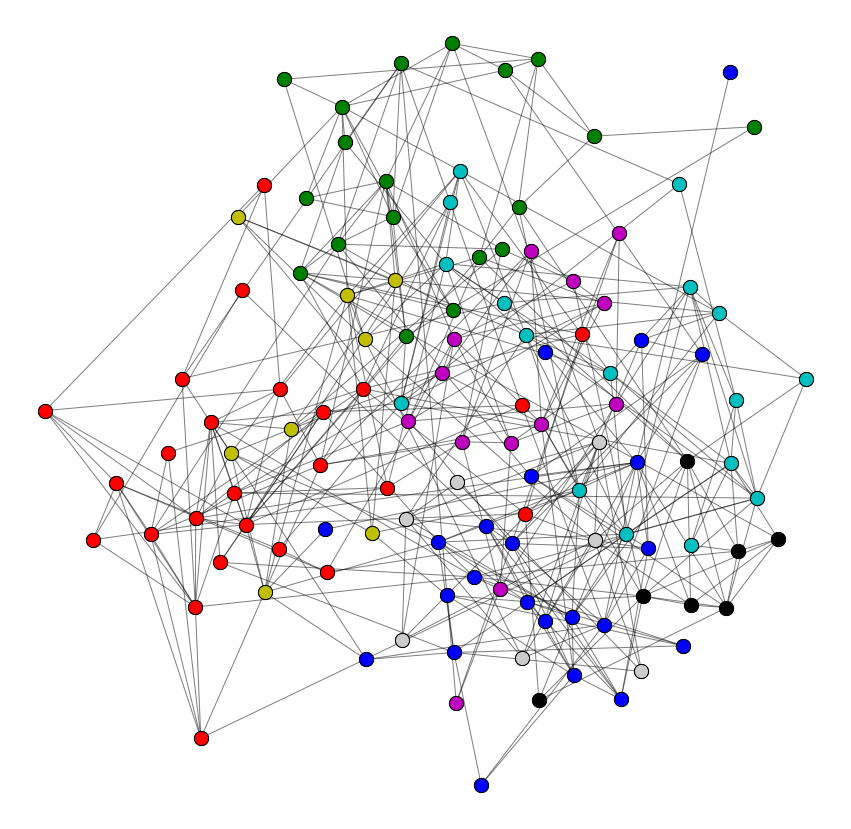

<Figure size 432x288 with 0 Axes>

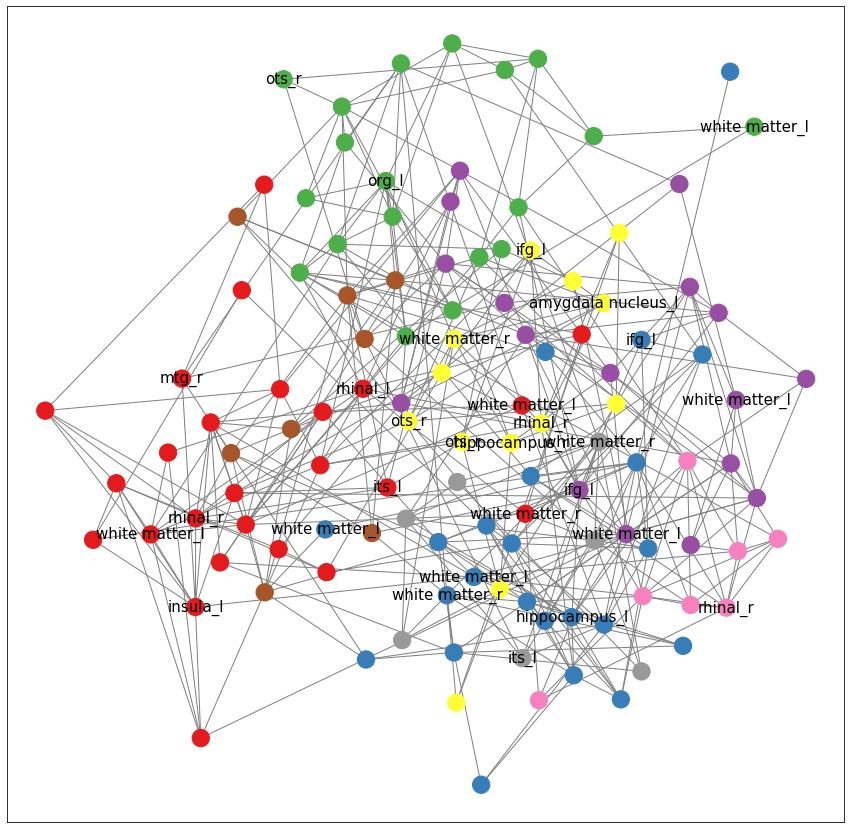

In [ ]:
pos = nx.drawing.layout.spring_layout(g_err)
lou(nbg_err,pos)
plotage(nbg_err,"comm_err_su_34.png","reg2")

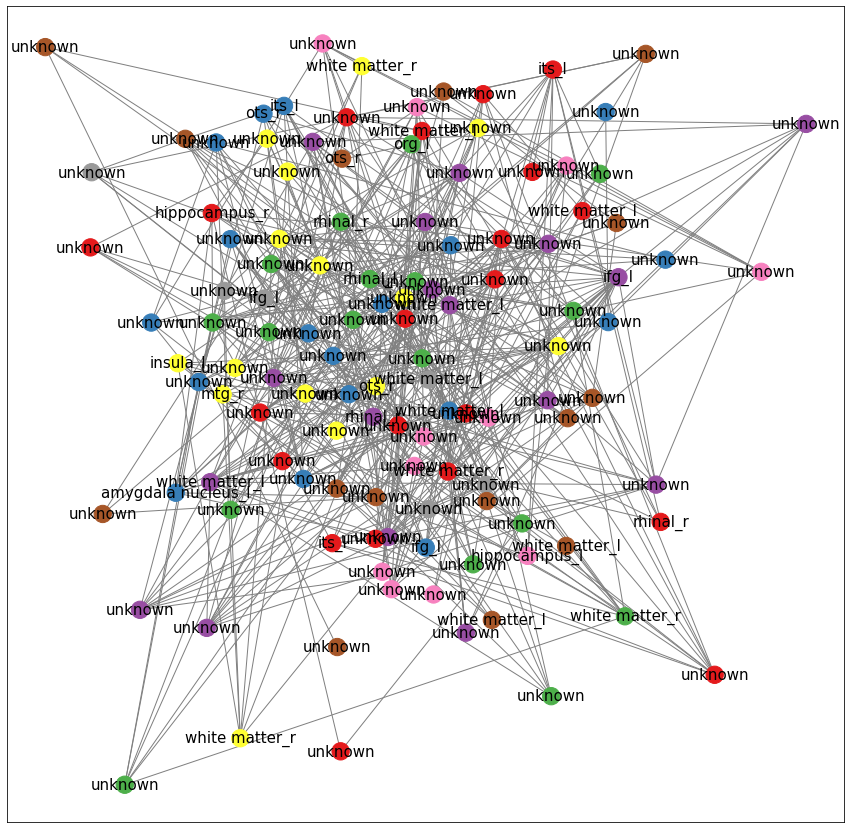

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
nx.draw_networkx(nbg_succ,font_size=15,edge_color="Grey",pos=pos,node_color=[x[1][0] for x in nbg_succ.nodes.data(data="community")],cmap='Set1',ax=ax,labels=dict(nbg_succ.nodes.data(data="reg2")))

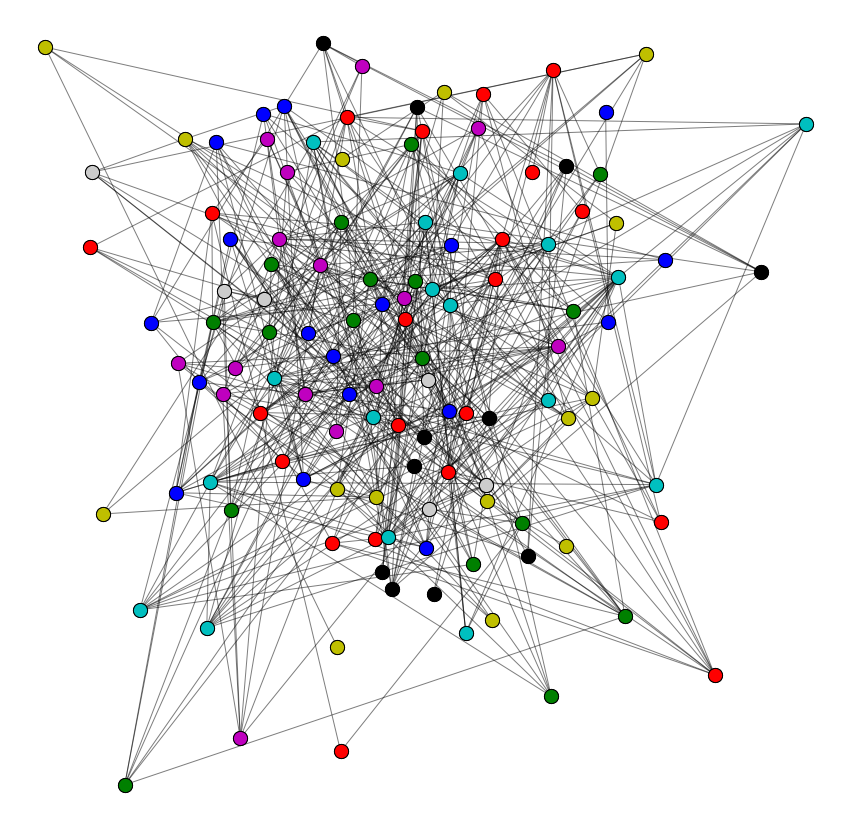

'\nfor i in g_ep_su:\n  for j in nx.connected_components(i):\n    print(len(j))\n'

<Figure size 432x288 with 0 Axes>

In [ ]:
pos = nx.drawing.layout.spring_layout(nbg_err)
lou(nbg_succ,pos)
"""
for i in g_ep_su:
  for j in nx.connected_components(i):
    print(len(j))
"""

In [ ]:
print(nbg_err.nodes.data(data="community"))
print("coucou",np.unique([x[1][0] for x in nbg_err.nodes.data(data="community") if not x[1] is None]))
pos = nx.drawing.layout.spring_layout(g_err)
lou(g_ep_er,pos)
lou(nbg_succ,pos)

[("tp'1-tp'2", None), ("tp'5-tp'6", None), ("a'7-a'8", None), ("b'4-b'5", None), ("h'2-h'3", None), ("h'9-h'10", None), ("or'11-or'12", None), ("pi'1-pi'2", None), ("pi'14-pi'15", None), ('tb2-tb3', None), ('h8-h9', None), ("b'10-b'11", None), ("t'7-t'8", None), ("or'3-or'4", None), ("of'9-of'10", None), ("of'12-of'13", None), ("of'13-of'14", None), ("ip'4-ip'5", None), ("tp'6-tp'7", None), ("gph'8-gph'9", None), ("of'8-of'9", None), ("ia'4-ia'5", None), ("tp'7-tp'8", None), ("tp'8-tp'9", None), ("b'9-b'10", None), ("gph'9-gph'10", None), ("t'1-t'2", None), ("or'5-or'6", None), ('b1-b2', None), ('b6-b7', None), ("tb'3-tb'4", None), ("b'12-b'13", None), ("h'1-h'2", None), ("pi'2-pi'3", None), ('tb1-tb2', None), ('tb9-tb10', None), ("tb'4-tb'5", None), ("tb'7-tb'8", None), ("a'8-a'9", None), ("ia'10-ia'11", None), ("pi'10-pi'11", None), ('b5-b6', None), ("tb'5-tb'6", None), ("of'4-of'5", None), ("ip'1-ip'2", None), ("ip'11-ip'12", None), ('h1-h2', None), ("tb'6-tb'7", None), ("ia'9-ia'10

NameError: ignored

In [ ]:
def clus_diff(G1,G2):
  #On récolte le nombre de communautée dans chaque graph
  c1 = np.unique([x[1][0] for x in G1.nodes.data(data="community")]) 
  c2 = np.unique([x[1][0] for x in G2.nodes.data(data="community")])

  #On créer 2 dataframe, pour montrer à quel point une communauté est inclue dans une autre
  df1 = pd.DataFrame(index=c1,columns=c2)
  df2 = pd.DataFrame(index=c2,columns=c1)

  #On calcul les coef qui valent nb_noeud_communs/nb_noeud_community
  for i in c1:
    df1.loc[i,:] = [len(set([x[0] for x in G1.nodes.data(data="community") if x[1][0] == i]).intersection(set([y[0] for y in G2.nodes.data(data="community") if y[1][0]==j])))/len(set([z[0] for z in G1.nodes.data(data="community") if z[1][0] == i])) for j in c2]
    df2.loc[:,i] = [len(set([x[0] for x in G1.nodes.data(data="community") if x[1][0] == i]).intersection(set([y[0] for y in G2.nodes.data(data="community") if y[1][0]==j])))/len(set([z[0] for z in G2.nodes.data(data="community") if z[1][0] == j])) for j in c2]

  return df1.astype(float),df2.astype(float)


Plot les dataframes

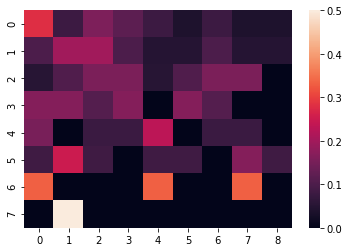

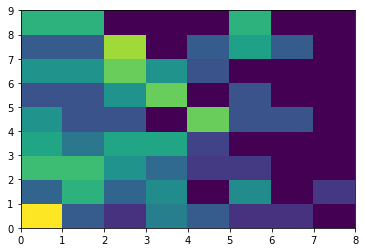

In [ ]:
d_err = d_err.astype(float)
d_succ= d_succ.astype(float)

import seaborn as sns
sns.heatmap(d_err)

plt.show()

plt.pcolor(d_succ)
plt.show()


#3.e Détection hierarchique de communauté et autres trucs

La section n'est pas finie, elle vise à découvrir l'organisation hierarchique des communautées dans le graphs en se basant sur l'article de (Sanchez-Rodriguez, Iturria-Medina, Mouches & Sotero; 2020)

In [ ]:
#walker = random.choices(g_err.nodes,k=100)
def walk(g,W=100,l=1000):
  import random

  g_new = [g.subgraph(c) for c in nx.connected_components(g) if len(c) > 10]
  if len(g_new) == 1:
    g_new = g_new[0]
  elif len(g_new) == 2:
    g_new = nx.compose(g_new[0],g_new[1])
  else:
    g_new = nx.compose(g_new)

  walker = np.empty((W,l),dtype=object)
  walk_hz = np.empty((W,l),dtype=np.int64)
  walker[:,0] = random.choices([x for x in g_new.nodes()],k=W)

  for i in range(1,l):
    walker[:,i] = [random.choice([x for x in g_new[walker[j,i-1]]]) for j in range(len(walker[:,0]))]

  for i in range(np.shape(walker)[1]):
    b = np.unique(walker[:,i],return_counts=True)
    walk_hz[:,i] = [b[1][np.where(b[0]==x)[0]][0] for x in walker[:,i]]

  return walker,walk_hz

In [ ]:
def zerocross(data,label,uniq):
  llabel = uniq
  grp = []
  s = 0
  n=-1
  c = 0
  for i in data:
    if s == 0:
      grp += [[]]
      n0 = i
      n+=1
      grp[n] += [label[c]]
      c+=1
      s=1
    elif not (i<=0 and n0>=0) or (i>=0 and n0<=0):
      grp[n] += [label[c]]
      n0=i
      c+=1
    else:
      grp += [[]]
      n0 = i
      n+=1
      grp[n] += [label[c]]
      c+=1
  out = np.empty((len(grp),len(llabel)),dtype='bool')
  for i in range(len(grp)):
    out[i,:] = [1 if x in grp[i] else 0 for x in llabel]
  
  return out


ez
8


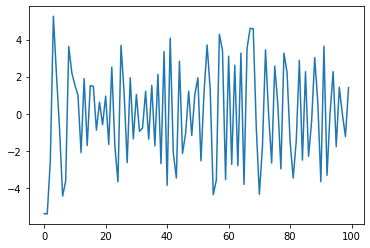

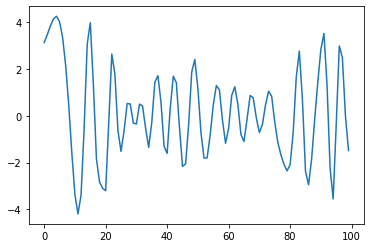

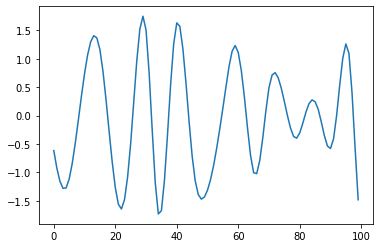

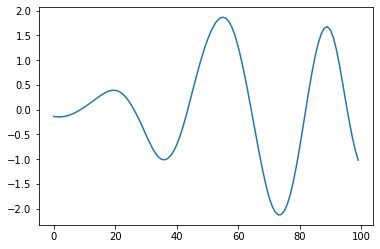

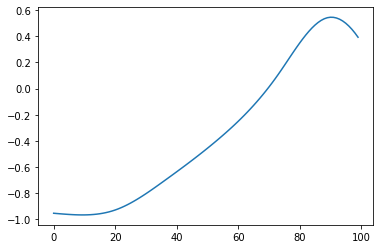

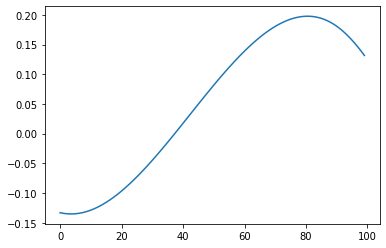

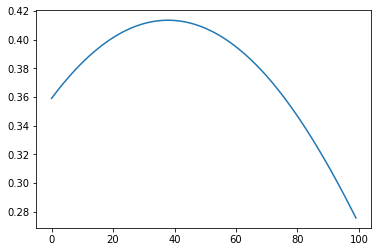

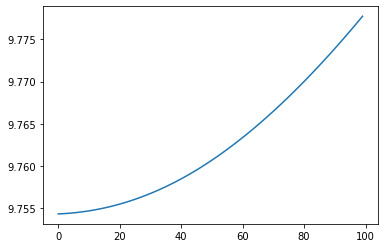

'\nfor i in range(np.shape(bli)[0])\n  for j in range(np.shape(bli)[1]):\n'

In [ ]:
from PyEMD import EMD
bla,bli = walk(g_err,W=1000,l=1000)
#bla[:,:,1] = bla[:,:,1].astype(np.int64,copy=False)
"""
print(type(bla[0,0,1]))
print([type(x) for x in bla[0,:,1] if (type(x) != type(bla[0,0,1]) or x == np.nan) ])
print([type(x) for x in bla[0,:,0]])
print(bla[0,:,1].dtype)

if np.isnan([x for x in bla[0,:,1]]).any():
  print("ok")
else:
  print("non nan")
plt.plot(bla[0,:100,1])
plt.show()
"""


"""
for i in range(np.shape(bli)[0])
  for j in range(np.shape(bli)[1]):
"""

In [ ]:
imf = np.empty((1000,4,1000),dtype=np.float64)
print("ez")
emd = EMD()
for i in range(np.shape(imf)[0]):
  imf[i,:,:] = emd.emd(bli[i,:])[:4]


ez


In [ ]:
lab = g_err.nodes()
imf1 = [zerocross(imf[i,0,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf1 = np.concatenate(imf1,axis=0)
imf2 = [zerocross(imf[i,1,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf2 = np.concatenate(imf2,axis=0)
imf3 = [zerocross(imf[i,2,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf3 = np.concatenate(imf3,axis=0)
imf4 = [zerocross(imf[i,3,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf4 = np.concatenate(imf4,axis=0)

Exploration des subgraph

In [ ]:
print([x[1] for x in g_err.nodes.data(data="rank")])

[0.0035798525738144674, 0.006164596179196885, 0.008180424997460183, 0.007523385524463438, 0.005022922979177967, 0.009258706322718071, 0.009423678521221567, 0.010287490580979185, 0.0076478364433642965, 0.010622568231669832, 0.01061969187780454, 0.008689361758445438, 0.008464745157771339, 0.004147709058578094, 0.00594690709665519, 0.008798689525476872, 0.006890506580444538, 0.010190007327993215, 0.011095431449902203, 0.00526816425091491, 0.00730775583000668, 0.0076412888384230025, 0.010823604495220475, 0.008754807170139664, 0.0033157170892954614, 0.008772003854378724, 0.006095033787469, 0.010766590873817369, 0.010435275150367922, 0.010603967857238626, 0.007265417436706678, 0.010030256715996496, 0.007455241191091552, 0.01086929853952004, 0.004867227407151762, 0.0052766430981742544, 0.004836881261677175, 0.006577399259212418, 0.010685655588633233, 0.004998227242732782, 0.010550742290269638, 0.009440053486401926, 0.00933208777621132, 0.0069988679940155805, 0.009126798755640021, 0.0085484269

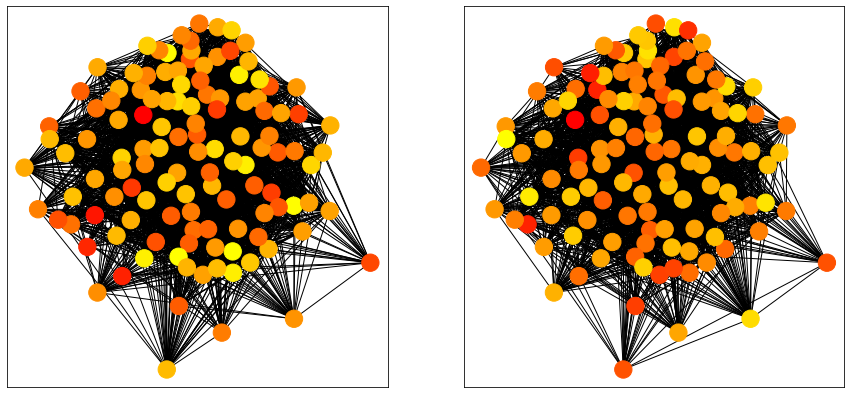

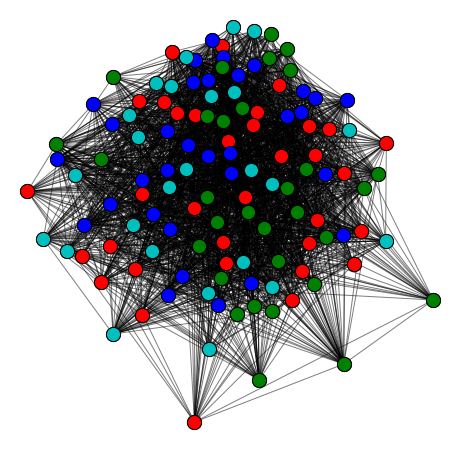

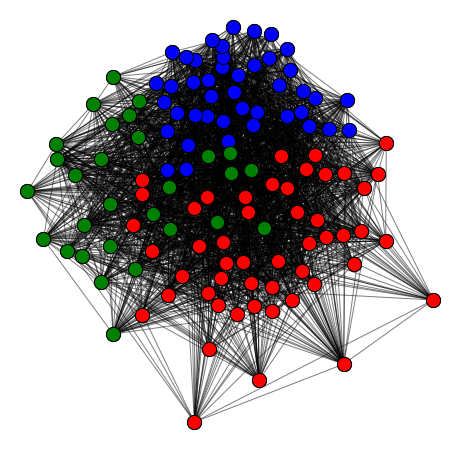

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,7))

nx.draw_networkx(g_err,pos=pos,ax=ax1,with_labels=False,node_color=[x[1] for x in g_err.nodes.data(data="rank")],cmap="autumn")
nx.draw_networkx(g_succ,pos=pos,ax=ax2,with_labels=False,node_color=[x[1] for x in g_succ.nodes.data(data="rank")],cmap="autumn")

plt.show()
plot_network_clusters(g_succ, louv_clust_succ, pos)
plt.show()
plot_network_clusters(g_succ, louv_clust_err, pos)

In [ ]:
!{sys.executable} -m pip install python-igraph

/bin/bash: {sys.executable}: command not found


In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Executing: /tmp/apt-key-gpghome.LGbiAZ0kfE/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Relea

In [ ]:
from graph_tool.all import *

g = collection.data["celegansneural"]
state = minimize_nested_blockmodel_dl(g)

state.draw()

In [ ]:
from cdlib import algorithms
from cdlib.viz import plot_network_clusters

#louv_clust_succ = louvain(g_succ,weight='weight')
inf = algorithms.angel(g_succ,min_community_size=5,threshold=0.25)
"""
## 1.c : Noter les communautés sur le graph de base
com = louv_clust.to_node_community_map()
nx.set_node_attributes(g_succ,com,"community")
"""
## 1.d : Visualiser les communautées
pos = nx.drawing.layout.spring_layout(g_succ)
plot_network_clusters(g_succ, inf, pos)
plt.show()

ModuleNotFoundError: ignored

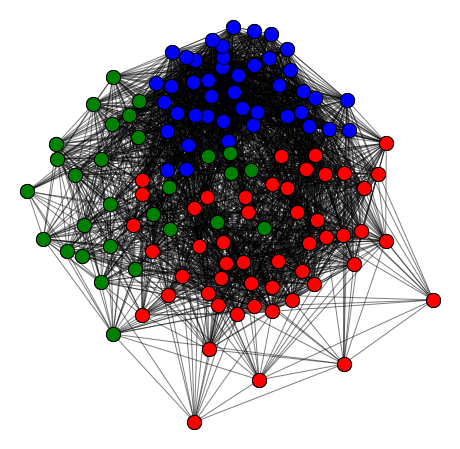

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters
louv_clust_err = louvain(g_err,weight='weight')

## 1.c : Noter les communautés sur le graph de base
com = louv_clust.to_node_community_map()
nx.set_node_attributes(g_err,com,"community")

## 1.d : Visualiser les communautées
#pos = nx.drawing.layout.spring_layout(g_err)
plot_network_clusters(g_err, louv_clust_err, pos)
plt.show()

In [ ]:
print([x for x in g_err.nodes() if g_err.nodes[x]["community"] == [0]])
a = [g_succ.nodes[x]["community"] for x in g_succ.nodes() if g_err.nodes[x]["community"]== [0]]
c_0 = sts.mode(a)[0][0]
l_0 = [x for x in g_succ.nodes() if g_succ.nodes[x]["community"] == c_0]
print(len([x for x in g_err.nodes() if x in l_0 and g_err.nodes[x]["community"]==[0]])/len(l_0))
print(l_0)
print(a)
print(c_0)
co_err = [g_err.nodes[x]["community"][0] for x in g_err.nodes()]
co_succ = [g_succ.nodes[x]["community"][0] for x in g_succ.nodes()]
int_err = set([x for x in co_err if sum([1 if y==x else 0 for y in co_err]) > 5])
int_succ = set([x for x in co_succ if sum([1 if y==x else 0 for y in co_succ]) > 5])
print(max(co_err))
print(max(co_succ))
print(int_err)
print(int_succ)

["tp'1-tp'2", "tp'5-tp'6", "tp'6-tp'7", "tp'7-tp'8", "tb'4-tb'5", "tb'6-tb'7", "tb'9-tb'10", "tb'11-tb'12", "a'8-a'9", "b'4-b'5", "b'6-b'7", "b'7-b'8", "b'8-b'9", "b'9-b'10", "b'11-b'12", "gph'6-gph'7", "h'5-h'6", "h'10-h'11", "h'11-h'12", "or'1-or'2", "or'2-or'3", "or'5-or'6", "or'8-or'9", "or'9-or'10", "or'10-or'11", "or'13-or'14", "of'1-of'2", "of'4-of'5", "of'6-of'7", "of'7-of'8", "of'8-of'9", "of'9-of'10", "of'12-of'13", "of'13-of'14", "ia'1-ia'2", "ia'2-ia'3", "ia'4-ia'5", "ia'5-ia'6", "ia'6-ia'7", "ip'13-ip'14", "pi'2-pi'3", "pi'8-pi'9", "pi'11-pi'12", 'tb9-tb10', 'b1-b2', 'b3-b4', 'b7-b8', 'b8-b9', 'b9-b10', 'b10-b11']
0.5806451612903226
["tp'1-tp'2", "tp'5-tp'6", "tp'7-tp'8", "tb'6-tb'7", "tb'7-tb'8", "tb'11-tb'12", "tb'12-tb'13", "a'3-a'4", "b'8-b'9", "b'11-b'12", "gph'5-gph'6", "gph'8-gph'9", "h'4-h'5", "or'1-or'2", "or'2-or'3", "or'4-or'5", "or'5-or'6", "or'7-or'8", "or'9-or'10", "or'10-or'11", "of'6-of'7", "of'7-of'8", "of'12-of'13", "ia'2-ia'3", "ia'6-ia'7", "ip'1-ip'2", 

Pour identifier quelles communautées pourraient se rapprocher de l'autre

In [ ]:
dic_err = {x : [] for x in int_err}
dic_succ = {x : [] for x in int_succ}
for i in int_err:
  for j in int_succ:
    dic_err[i] += [len([x for x in g_err.nodes() if (g_err.nodes[x]["community"][0] == i) and (g_succ.nodes[x]["community"][0]==j)])/len([x for x in g_succ.nodes if g_succ.nodes[x]["community"][0]==j])]
    dic_succ[j] += [len([x for x in g_succ.nodes() if (g_succ.nodes[x]["community"][0] == j) and (g_err.nodes[x]["community"][0]==i)])/len([x for x in g_err.nodes if g_err.nodes[x]["community"][0]==i])]
print(dic_succ)
print(dic_err)

{0: [0.34, 0.2558139534883721, 0.20689655172413793], 1: [0.14, 0.3488372093023256, 0.3448275862068966], 2: [0.36, 0.18604651162790697, 0.1724137931034483], 3: [0.16, 0.20930232558139536, 0.27586206896551724]}
{0: [0.5, 0.21875, 0.5806451612903226, 0.32], 1: [0.3235294117647059, 0.46875, 0.25806451612903225, 0.36], 2: [0.17647058823529413, 0.3125, 0.16129032258064516, 0.32]}


324
666.5


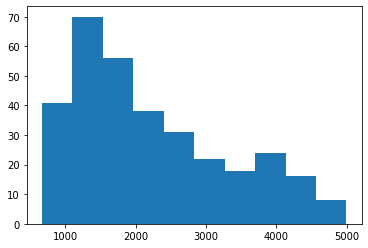

In [ ]:
print(len((ep.metadata.loc[(ep.metadata["rt"]!=0.0) & (ep.metadata["rt"]<5000.0)&(ep.metadata["error"]==0.0),'rt'])))
print(min(ep.metadata.loc[ep.metadata['rt']!=0.0,'rt']))
plt.hist(ep.metadata.loc[(ep.metadata["rt"]!=0.0) & (ep.metadata["rt"]<5000.0)&(ep.metadata["error"]==0.0),'rt'])
plt.show()

In [ ]:

cor_f = []
cor_s = []
sl = [x/10 for x in range(6)]
print(sl)
for i in range(5):
  print(sl[i])
  print(sl[i+1])
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).get_data()
  cor_f += [df.corr()]
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
  cor_s += [df.corr()]
  



[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
0.0
0.1


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.1
0.2


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.2
0.3


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.3
0.4


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.4
0.5


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


In [ ]:
j_f = [cor_f[x].replace(to_replace=1.0,value=0.0,inplace=False) for x in range(len(cor_f))] 
j_s = [cor_s[x].replace(to_replace=1.0,value=0.0,inplace=False) for x in range(len(cor_s))]
print(jeu)

                   time         epoch  tp'1-tp'2  ...     h3-h4     h4-h5     h8-h9
time       0.000000e+00  4.100132e-18  -0.021002  ... -0.034513 -0.047117  0.001173
epoch      4.100132e-18  0.000000e+00   0.207513  ...  0.097737  0.093916 -0.037951
tp'1-tp'2 -2.100171e-02  2.075129e-01   0.000000  ...  0.033744 -0.047548  0.006026
tp'2-tp'3 -2.575999e-02  1.921106e-01   0.096294  ...  0.013943  0.020689 -0.035950
tp'3-tp'4  6.127708e-02  3.104688e-02   0.131113  ...  0.036887 -0.007110 -0.067056
...                 ...           ...        ...  ...       ...       ...       ...
h1-h2     -7.219948e-02  1.031213e-01  -0.008452  ...  0.318247  0.209157  0.080871
h2-h3     -4.189718e-03  2.359616e-02   0.036579  ...  0.282668  0.033259 -0.028066
h3-h4     -3.451267e-02  9.773681e-02   0.033744  ...  0.000000  0.418069 -0.012527
h4-h5     -4.711744e-02  9.391612e-02  -0.047548  ...  0.418069  0.000000 -0.084020
h8-h9      1.173493e-03 -3.795065e-02   0.006026  ... -0.012527 -0.084020  0

In [ ]:
ma_f = [{x : [y for y in j_f[a][x]] for x in j_f[a].columns} for a in range(len(j_f))]
ma_s = [{x : [y for y in j_s[a][x]] for x in j_s[a].columns} for a in range(len(j_s))]

In [ ]:
li_f = [[(max(ma_f[a][b]),b)for b in ma_f[a].keys()] for a in range(len(ma_f))]
li_s = [[(max(ma_s[a][b]),b)for b in ma_s[a].keys()] for a in range(len(ma_s))]

In [ ]:
sorted(li_s[0],key=lambda a: a[0],reverse=True)


[(0.7661954987469561, "t'4-t'5"),
 (0.7661954987469561, "t'5-t'6"),
 (0.7371069990212991, "ip'11-ip'12"),
 (0.7371069990212991, "ip'12-ip'13"),
 (0.6510781922869467, "t'6-t'7"),
 (0.6410016969144692, "gph'9-gph'10"),
 (0.6410016969144692, "gph'10-gph'11"),
 (0.6083522062030047, "ia'8-ia'9"),
 (0.6083522062030047, "ia'10-ia'11"),
 (0.6081694436416689, "or'10-or'11"),
 (0.6081694436416689, "or'12-or'13"),
 (0.5999979653604157, "or'8-or'9"),
 (0.5999979653604157, "or'9-or'10"),
 (0.5978687909554, "b'6-b'7"),
 (0.5978687909554, "b'7-b'8"),
 (0.5585103231386979, "b'11-b'12"),
 (0.5585103231386979, "b'12-b'13"),
 (0.5529048232205391, "or'7-or'8"),
 (0.5513097532186856, "a'10-a'11"),
 (0.5513097532186856, "a'12-a'13"),
 (0.5383812642013175, 'tb3-tb4'),
 (0.5383812642013175, 'tb4-tb5'),
 (0.5352997647321122, "gph'8-gph'9"),
 (0.5269051190619289, "ia'5-ia'6"),
 (0.5269051190619289, "ia'6-ia'7"),
 (0.5222093261705045, "b'5-b'6"),
 (0.5082968352114643, "pi'4-pi'5"),
 (0.5082968352114643, "pi'6-pi

# 4 - ML

Section Machine Learning visant à essayer de voir s'il y a des régularité qui permettraient de deviner à quelle situation correspond un graph 

In [ ]:
a = np.arange(27).reshape(3,9)
print(a)
rng = np.random.default_rng()
b = rng.permutation(a,axis=1)
print(b)

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]]
[[ 2  6  5  1  8  3  7  4  0]
 [11 15 14 10 17 12 16 13  9]
 [20 24 23 19 26 21 25 22 18]]


In [ ]:
con = ep.info["ch_names"]

In [ ]:

def Epoch_NBS(ep,con,p=100):
  rng = np.random.default_rng()
  data = [rng.permutation(ep,axis=1) for i in range(p)]
  pper = np.empty((p,len(con),len(con)),dtype=object)
  
  for i in range(len(data)):

    pper[i,:,:] = np.absolute(sts.spearmanr(data[i],axis=1)[0])
    """pper[i,:,:] = [[abs(sts.spearmanr(data[i][a],data[i][b])[0]) for b in range(len(con))] for a in range(len(con))]"""
  
  t_sig = np.array([[abs(sts.spearmanr(ep[a],ep[b])[0]) for b in range(len(con))] for a in range(len(con))])

  G = nx.Graph()
  print(t_sig[0,:])
  for i in range(len(con)):
    
    add = [x for x in range(len(con)) if t_sig[i,x] > np.sort(pper[:,i,x])[math.floor(0.5*p)-1]]
    
    if len(add) == 0:
      pass
    else:
      G.add_edges_from([(con[i],con[x],{"weight":t_sig[i,x]}) for x in add if not con[i] == x])
  return G

In [ ]:

def Epoch_NBS(ep,con,cut,p=100):
  """
  rng = np.random.default_rng()
  data = [rng.permutation(ep,axis=1) for i in range(p)]
  pper = np.empty((p,len(con),len(con)),dtype=object)
  
  for i in range(len(data)):

    pper[i,:,:] = np.absolute(sts.spearmanr(data[i],axis=1)[0])
    pper[i,:,:] = [[abs(sts.spearmanr(data[i][a],data[i][b])[0]) for b in range(len(con))] for a in range(len(con))]
  """
  #t_sig = np.array([[abs(sts.spearmanr(ep[a],ep[b])[0]) for b in range(len(con))] for a in range(len(con))])
  t_sig = np.absolute(sts.spearmanr(ep,axis=1)[0])
  G = nx.Graph()
  print(p)
  for i in range(len(con)):
    
    add = [x for x in range(len(con)) if t_sig[i,x] > cut[i,x]]
    
    if len(add) == 0:
      pass
    else:
      G.add_edges_from([(con[i],con[x],{"weight":t_sig[i,x]}) for x in add if not con[i] == con[x]])
  return G

In [ ]:
print(ep.info["ch_names"])

["tp'1-tp'2", "tp'5-tp'6", "tp'6-tp'7", "tp'7-tp'8", "tp'8-tp'9", "tb'3-tb'4", "tb'4-tb'5", "tb'5-tb'6", "tb'6-tb'7", "tb'7-tb'8", "tb'8-tb'9", "tb'9-tb'10", "tb'10-tb'11", "tb'11-tb'12", "tb'12-tb'13", "a'3-a'4", "a'4-a'5", "a'5-a'6", "a'6-a'7", "a'7-a'8", "a'8-a'9", "b'4-b'5", "b'5-b'6", "b'6-b'7", "b'7-b'8", "b'8-b'9", "b'9-b'10", "b'10-b'11", "b'11-b'12", "b'12-b'13", "gph'4-gph'5", "gph'5-gph'6", "gph'6-gph'7", "gph'7-gph'8", "gph'8-gph'9", "gph'9-gph'10", "t'1-t'2", "t'2-t'3", "t'7-t'8", "h'1-h'2", "h'2-h'3", "h'3-h'4", "h'4-h'5", "h'5-h'6", "h'8-h'9", "h'9-h'10", "h'10-h'11", "h'11-h'12", "or'1-or'2", "or'2-or'3", "or'3-or'4", "or'4-or'5", "or'5-or'6", "or'6-or'7", "or'7-or'8", "or'8-or'9", "or'9-or'10", "or'10-or'11", "or'11-or'12", "or'12-or'13", "or'13-or'14", "of'1-of'2", "of'2-of'3", "of'3-of'4", "of'4-of'5", "of'5-of'6", "of'6-of'7", "of'7-of'8", "of'8-of'9", "of'9-of'10", "of'10-of'11", "of'11-of'12", "of'12-of'13", "of'13-of'14", "ia'1-ia'2", "ia'2-ia'3", "ia'3-ia'4", "i

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
"""
con = ep.info["ch_names"]
# 1) On détermine 200 noeuds qui seront tiré des réseaux erreurs et succès
X_err = [[1 if i in nbg_err[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_err.nodes()],k=1000)]
X_succ = [[1 if i in nbg_succ[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_succ.nodes()],k=1000)]
lab = [1 if x < 1000 else 0 for x in range(2000)]
X= X_err+X_succ

# 2) On fit le svm
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X,lab)

# 3) Est ce que le fit est bon ?
"""

# 3) On génère des données epoch par epoch
rnd = [random.randint(0,np.shape(epraw_err)[0]) for i in range(5)]
g_ep_er = [Epoch_NBS(epraw_err[i,:,:],con,cutoff,p=i) for i in range(np.shape(epraw_err)[0])]
rnd = [random.randint(0,np.shape(epraw_succ)[0]) for i in range(5)]
g_ep_su = [Epoch_NBS(epraw_succ[i,:,:],con,cutoff,p=i) for i in range(np.shape(epraw_succ)[0])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
for i in g_ep_er:
  for c in nx.connected_components(i):
    print(len(c))

Permutation score =  0.6238095238095238
P_val =  0.009900990099009901
Précision =  0.5714285714285714
Tru neg =  11
Fal pos =  23
Fal neg =  7
Tru pos =  29


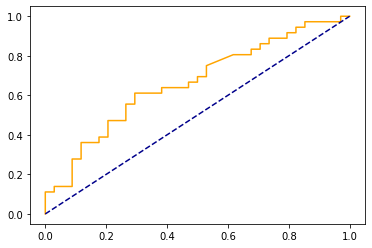

In [ ]:
from sklearn.model_selection import permutation_test_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, balanced_accuracy_score
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

# 1) On détermine 200 noeuds qui seront tiré des réseaux erreurs et succès
#X_err = [[1 if i in nbg_err[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_err.nodes()],k=100)]
#X_succ = [[nbg_err[x][i]["weight"] if i in nbg_succ[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_succ.nodes()],k=100)]
X_err = [[nbg_err[x][i]["weight"] if i in nbg_err[x] else 0 for i in con] for x in nbg_err.nodes()]
X_succ = [[nbg_succ[x][i]["weight"] if i in nbg_succ[x] else 0 for i in con] for x in nbg_succ.nodes()]
l = [1 if x < len(X_err) else 0 for x in range(len(X_err)+len(X_succ))]
X= X_err+X_succ

# 2) On fit le svm
"""
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
scal = [1/(len(X[0])*np.var(X))]
gammas += scal
kerns = ('linear','rbf')
parameters = {'kernel':('linear', 'rbf'), 'C':Cs,'gamma':gammas}

#Optimisation des Hyper-paramètres
sv = svm.SVC(probability=True)
clfCV = GridSearchCV(sv,parameters,scoring='balanced_accuracy')
clfCV.fit(X,l)
clf = clfCV.best_estimator_ #Retourne un SVM ayant les meilleurs paramètres trouvé
"""


score, perm, p_val = permutation_test_score(clf,X,l)
print("Permutation score = ",score)
print("P_val = ",p_val)
X_train, X_test, y_train, y_test = train_test_split(X,l,test_size=0.33,random_state=42)
clf.fit(X_train,y_train)
print("Précision = ",accuracy_score(y_test,clf.predict(X_test)))
prec = confusion_matrix(y_test,clf.predict(X_test))
print('Tru neg = ',prec[0][0])
print('Fal pos = ',prec[0][1])
print('Fal neg = ',prec[1][0])
print('Tru pos = ',prec[1][1])

pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.show()

(100, 21)
(200, 21)


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NameError: ignored

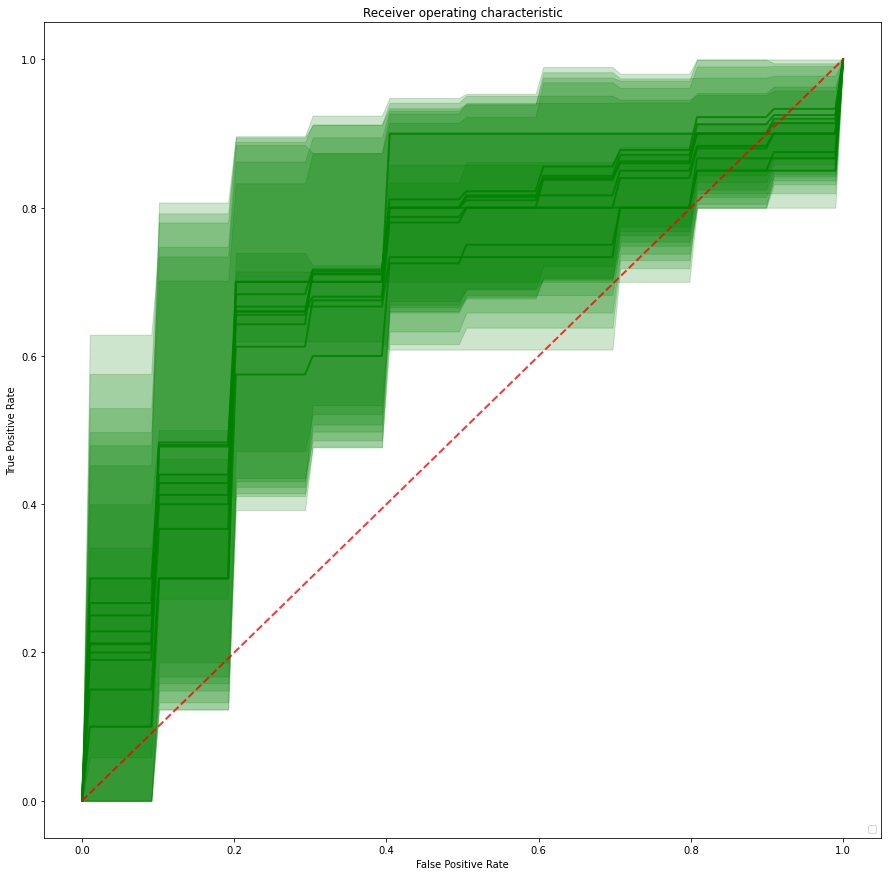

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
nb_comp = 5
nb_ep = 100
nb_node = 100
"""
X_e = np.empty((nb_ep,nb_node*nb_comp))
X_s = np.empty((nb_ep,nb_node*nb_comp))
"""
X_e = []
X_s = []
n_e = []
n_s = []

co_err = {a : [x[0] for x in nbg_err.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_err.nodes.data(data='community')])}
co_succ = {a : [x[0] for x in nbg_succ.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_succ.nodes.data(data='community')])}
c =0
pca = PCA(n_components=nb_comp)
for i in random.choices(range(len(g_ep_er)),k=nb_ep):
  
  #Variation Community Detection
  #1) On va assigner une communauté à chaque noeud de chaque graph
  vec = []
  louv_clust = louvain(g_ep_er[i],weight='weight')
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(g_ep_er[i],com,"community")
  co_n = {a : [x[0] for x in g_ep_er[i].nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in g_ep_er[i].nodes.data(data='community')])}
  
  #2) On crée autant de vecteur que de communauté dans lequel, chaque dimension correspond au coefficient de jaccard
  #   Entre cette commauté et celles obtenues par les potentiel évoqués
  """
  for i in co_n.keys():
    vec += [[len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for j in co_err.keys()] + [len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for j in co_succ.keys()]]
  X_e += vec
  """
  X_e += [[max([len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for i in co_n.keys()]) for j in co_err.keys()] + [max([len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for i in co_n.keys()]) for j in co_succ.keys()]]
  #Variation PageRank
  """
  it = nx.clustering(g_ep_er[i])
  X_e += [[it[x] if x in g_ep_er[i].nodes() else 0 for x in con]]
  """

  #Variation Poids, le n_e était pour voir s'il y avait des noeuds qui permettaient de mieux prédire ou pas
  """
  node = random.choices([x for x in con if x in g_ep_er[i].nodes()],k=50)
  X_e += [[g_ep_er[i][x][j]["weight"] if j in g_ep_er[i][x] else 0 for j in con] for x in node]
  n_e += node
  """
  
  #Variation vecteur binaire d'adjacence
  #X_e += [[1 if j in g_ep_er[i][x] else 0 for j in con] for x in g_ep_er[i].nodes()]

  #Variation Poids + t-SNE
  """
  node = random.choices([x for x in con if x in g_ep_er[i].nodes()],k=nb_node)
  #emb = TSNE(n_components=nb_comp).fit_transform([[g_ep_er[i][x][j]["weight"] if j in g_ep_er[i][x] else 0 for j in con] for x in node])
  emb = pca.fit_transform([[1 if j in g_ep_er[i][x] else 0 for j in con] for x in node])
  print(np.shape(emb))
  X_e[c,:] = np.reshape(emb,(np.shape(emb)[0]*np.shape(emb)[1]))
  c+=1
  """
print(np.shape(X_e))
c=0
for i in random.choices(range(len(g_ep_su)),k=nb_ep):
  
  vec = []
  #Variation Community Detection
  #1) On va assigner une communauté à chaque noeud de chaque graph
  louv_clust = louvain(g_ep_su[i],weight='weight')
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(g_ep_su[i],com,"community")
  co_n = {a : [x[0] for x in g_ep_su[i].nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in g_ep_su[i].nodes.data(data='community')])}
  
  #2) On crée autant de vecteur que de communauté dans lequel, chaque dimension correspond au coefficient de jaccard
  #   Entre cette commauté et celles obtenues par les potentiel évoqués
  """
  for i in co_n.keys():
    vec += [[len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for j in co_err.keys()] + [len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for j in co_succ.keys()]]
  X_s += vec
  """
  X_s += [[max([len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for i in co_n.keys()]) for j in co_err.keys()] + [max([len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for i in co_n.keys()]) for j in co_succ.keys()]]

  #Variation PageRank
  """
  it = nx.clustering(g_ep_su[i])
  X_s += [[it[x] if x in g_ep_su[i].nodes() else 0 for x in con]]
  print(np.shape(X_s))
  """
  #Variation vecteur binaire d'adjacence
  #X_s += [[1 if j in g_ep_su[i][x] else 0 for j in con] for x in g_ep_su[i].nodes()]

  #Variation Poids, le n_e était pour voir s'il y avait des noeuds qui permettaient de mieux prédire ou pas
  """
  node = random.choices([x for x in con if x in g_ep_su[i].nodes()],k=50)
  X_s += [[g_ep_su[i][x][j]["weight"] if j in g_ep_su[i][x] else 0 for j in con] for x in node]
  n_s += node
  """

  #Variation Poids + t-SNE
  """
  node = random.choices([x for x in con if x in g_ep_su[i].nodes()],k=nb_node)
  #emb = TSNE(n_components=nb_comp).fit_transform([[g_ep_su[i][x][j]["weight"] if j in g_ep_su[i][x] else 0 for j in con] for x in node])
  emb = pca.fit_transform([[1 if j in g_ep_su[i][x] else 0 for j in con] for x in node])
  X_s[c,:] = np.reshape(emb,(np.shape(emb)[0]*np.shape(emb)[1]))
  c+=1
  """
X = np.concatenate((X_e,X_s))
print(np.shape(X))
l = [1 if x < len(X_e) else 0 for x in range(len(X))]
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
N = n_e+n_s
colo = ["red","green","blue","yellow","orange","purple","black"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)


X_train, X_test, y_train, y_test = train_test_split(X,l,test_size=0.33,random_state=42)

# Bayesian Optimization
opt = BayesSearchCV(
      svm.SVC(),
      {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
      },
      n_iter=32,
      cv=3
            )
      
opt.fit(X, l)
clf = opt.best_estimator_

cv = StratifiedKFold(n_splits=10)


ga = 0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = np.array(X)
y = np.array(l)

for ga, (train, test) in enumerate(cv.split(X, y)):
  clf.fit(X[train], y[train])
  viz = plot_roc_curve(clf, X[test], y[test],alpha=0.0, lw=1, ax=ax,label=None)
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color="green",
              lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="green", alpha=.2,)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)
fig.savefig("ROC_bopt.png")


score, perm, p_val = permutation_test_score(clf,X,l,scoring="balanced_accuracy")
print("Précision = ",score)
print("P_val = ",p_val)

clf.fit(X_train,y_train)
print("Précision = ",balanced_accuracy_score(y_test,clf.predict(X_test)))
prec = confusion_matrix(y_test,clf.predict(X_test))
print('Tru neg = ',prec[0][0])
print('Fal pos = ',prec[0][1])
print('Fal neg = ',prec[1][0])
print('Tru pos = ',prec[1][1])

pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.show()



In [ ]:
pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.savefig("roc_pagerank_unbalanced_450vecteur.png")

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters

louv_clust = louvain(nbg_err,weight='weight')
com = louv_clust.to_node_community_map()
nx.set_node_attributes(nbg_err,com,"community")
print(nbg_err.nodes.data(data="community"))

co_err = {a : [x[0] for x in nbg_err.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_err.nodes.data(data='community')])}

louv_clust = louvain(nbg_succ,weight='weight')
com = louv_clust.to_node_community_map()
nx.set_node_attributes(nbg_succ,com,"community")
print(nbg_succ.nodes.data(data="community"))

co_succ = {a : [x[0] for x in nbg_succ.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_succ.nodes.data(data='community')])}

ke = []
vec = [[len(set(co_succ[i]).intersection(co_err[j]))/len(set(co_succ[i]).union(co_err[j])) for j in co_err.keys()] for i in co_succ.keys()]
vec += [[len(set(co_succ[i]).intersection(co_succ[j]))/len(set(co_succ[i]).union(co_succ[j])) for j in co_succ.keys()] for i in co_succ.keys()]
for i in vec:
  print(i)
#jacc = [[set(co_succ[i] for j in co_err.keys()+co_succ.keys())] for i in co_succ.keys()]

[("tp'1-tp'2", [0]), ("a'8-a'9", [0]), ("t'1-t'2", [1]), ("h'1-h'2", [0]), ("ia'2-ia'3", [0]), ("tp'5-tp'6", [1]), ("b'8-b'9", [1]), ("tp'6-tp'7", [2]), ("tb'4-tb'5", [2]), ("gph'4-gph'5", [2]), ("h'5-h'6", [3]), ("of'1-of'2", [2]), ("of'6-of'7", [4]), ("of'13-of'14", [0]), ("pi'10-pi'11", [2]), ("tp'7-tp'8", [4]), ("b'6-b'7", [4]), ("or'4-or'5", [3]), ("ip'13-ip'14", [4]), ("pi'14-pi'15", [6]), ("tp'8-tp'9", [0]), ('tb2-tb3', [0]), ("tb'3-tb'4", [2]), ("or'9-or'10", [0]), ("of'7-of'8", [2]), ("tb'10-tb'11", [4]), ("tb'6-tb'7", [9]), ('b4-b5', [9]), ("tb'7-tb'8", [1]), ("b'12-b'13", [1]), ("ip'2-ip'3", [1]), ("ip'3-ip'4", [5]), ("tb'8-tb'9", [0]), ("or'10-or'11", [6]), ("of'12-of'13", [0]), ("ia'10-ia'11", [0]), ('tb9-tb10', [0]), ("tb'9-tb'10", [0]), ("a'4-a'5", [0]), ("gph'9-gph'10", [0]), ('b11-b12', [0]), ("b'11-b'12", [4]), ("t'7-t'8", [4]), ("tb'11-tb'12", [7]), ("a'7-a'8", [7]), ("or'8-or'9", [7]), ('b9-b10', [5]), ("tb'12-tb'13", [2]), ("a'3-a'4", [6]), ("a'5-a'6", [6]), ("t'2-

# 5 - Coloration de Graph

L'idée est d'essayer les combinaisons de contacts les plus intéressants pour le SVM en utilisant des outils de coloration de graphs qui permettent de colorier les noeuds non liés entre eux en utilisant le moins de couleurs

Étant donné que les noeuds sont liés entre eux si leur activité est corrélée, prendre un ensemble de noeuds non colorés serait peut être plus intéressant

1 - A On créer un Graph qui prend tous les noeuds des deux graphs

In [ ]:
nbg_fus = nx.compose(nbg_err,nbg_succ)

1 - B Coloration des noeuds !

In [ ]:
col = nx.greedy_color(nbg_succ)

In [ ]:
print(col.items())
print([x for x in set([x[1] for x in col.items()])])

dict_items([('b12-b13', 0), ("h'1-h'2", 0), ('h8-h9', 0), ("b'12-b'13", 0), ("ia'7-ia'8", 1), ("h'5-h'6", 1), ("gph'6-gph'7", 1), ("gph'4-gph'5", 2), ("b'11-b'12", 0), ("or'4-or'5", 2), ("of'9-of'10", 1), ('h1-h2', 1), ('b3-b4', 1), ("or'11-or'12", 1), ("ia'3-ia'4", 1), ("ip'3-ip'4", 2), ("pi'2-pi'3", 1), ("pi'10-pi'11", 2), ('b11-b12', 1), ("of'1-of'2", 2), ("tp'5-tp'6", 1), ("tp'6-tp'7", 1), ("tp'7-tp'8", 1), ("tp'8-tp'9", 0), ("tb'10-tb'11", 1), ("ia'8-ia'9", 1), ("ia'6-ia'7", 1), ("gph'8-gph'9", 1), ("or'1-or'2", 1), ("ia'5-ia'6", 1), ("ia'11-ia'12", 1), ("ip'2-ip'3", 1), ('tb1-tb2', 2), ('b6-b7', 1), ("gph'5-gph'6", 2), ("of'6-of'7", 2), ('tb2-tb3', 2), ("gph'7-gph'8", 1), ("h'9-h'10", 2), ("or'6-or'7", 1), ("or'8-or'9", 1), ("ip'4-ip'5", 1), ('b10-b11', 2), ("h'3-h'4", 1), ("of'3-of'4", 2), ("h'10-h'11", 1), ("or'5-or'6", 1), ("tb'3-tb'4", 1), ("tb'4-tb'5", 1), ("tb'5-tb'6", 1), ("tb'6-tb'7", 1), ("tb'7-tb'8", 1), ("tb'11-tb'12", 1), ("tb'12-tb'13", 2), ("a'4-a'5", 1), ("b'4-b'5"

In [ ]:
interest = ["b'7-b'8","of'2-of'3","ia'11-ia'12","ip'4-ip'5","of'10-of'11","h'5-h'6","ip'11-ip'12","a'7-a'8","ia'7-ia'8","t'2-t'3"]

[]

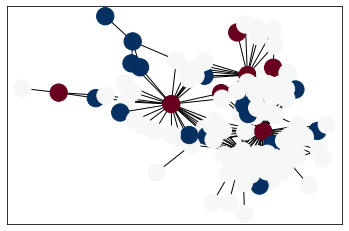

In [ ]:
pos = nx.drawing.layout.spring_layout(nbg_succ)
nx.draw_networkx(nbg_succ,pos=pos,with_labels=False,node_color=[x[1] for x in col.items()],cmap="RdBu")
plt.plot()

In [ ]:
print([col[x] for x in interest if x in col.keys()])

[1, 2, 3, 1, 1, 1, 2, 1, 1]


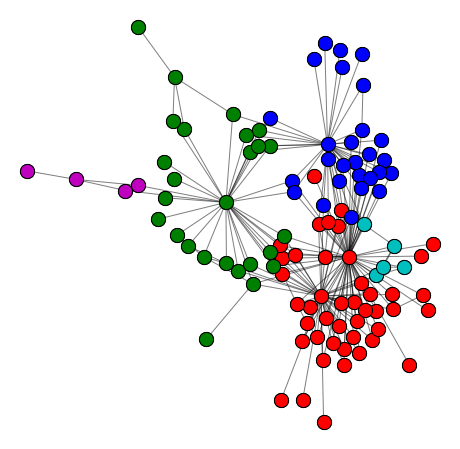

In [ ]:
lou(nbg_succ,pos)

In [ ]:
lou(nbg_err,pos)

In [ ]:
print(nbg_succ.nodes.data(data="community"))

[("tp'5-tp'6", [1]), ("h'3-h'4", [1]), ('b12-b13', [0]), ('h8-h9', [1]), ("tp'6-tp'7", [0]), ("b'12-b'13", [2]), ("h'1-h'2", [0]), ("tp'7-tp'8", [3]), ("gph'4-gph'5", [3]), ("of'1-of'2", [3]), ("tp'8-tp'9", [4]), ("ia'6-ia'7", [4]), ('b1-b2', [4]), ("tb'3-tb'4", [0]), ("tb'4-tb'5", [0]), ("tb'5-tb'6", [0]), ("tb'6-tb'7", [0]), ("tb'7-tb'8", [0]), ("tb'8-tb'9", [0]), ("tb'10-tb'11", [2]), ("tb'11-tb'12", [0]), ("tb'12-tb'13", [0]), ("a'4-a'5", [1]), ("a'5-a'6", [1]), ("a'6-a'7", [0]), ("a'7-a'8", [1]), ('b7-b8', [1]), ("a'8-a'9", [2]), ('tb1-tb2', [2]), ('h2-h3', [2]), ("b'4-b'5", [3]), ("b'5-b'6", [2]), ("ia'7-ia'8", [2]), ("b'6-b'7", [0]), ("b'7-b'8", [1]), ("b'8-b'9", [3]), ("b'10-b'11", [1]), ('tb2-tb3', [1]), ("b'11-b'12", [4]), ("ip'11-ip'12", [4]), ("gph'9-gph'10", [2]), ("t'2-t'3", [2]), ("h'8-h'9", [2]), ("h'10-h'11", [2]), ("or'1-or'2", [2]), ("or'2-or'3", [2]), ("or'4-or'5", [2]), ("or'5-or'6", [2]), ("of'7-of'8", [2]), ("of'9-of'10", [0]), ("ia'2-ia'3", [1]), ("ia'11-ia'12",

In [ ]:
com = {a : [y[0] for y in nbg_succ.nodes.data(data="community") if y[1][0] == a] for a in set([x[1][0] for x in nbg_succ.nodes.data(data="community")])}

In [ ]:
print(com)

{0: ['b12-b13', "tp'6-tp'7", "h'1-h'2", "tb'3-tb'4", "tb'4-tb'5", "tb'5-tb'6", "tb'6-tb'7", "tb'7-tb'8", "tb'8-tb'9", "tb'11-tb'12", "tb'12-tb'13", "a'6-a'7", "b'6-b'7", "of'9-of'10", "ip'2-ip'3", 'b6-b7', "gph'7-gph'8", "h'5-h'6", "h'9-h'10", "or'7-or'8", "or'8-or'9", "of'6-of'7", "of'13-of'14", "ia'5-ia'6", "ia'8-ia'9", "ia'10-ia'11", "ia'12-ia'13", "ip'5-ip'6", "pi'1-pi'2", "pi'10-pi'11", 'tb9-tb10', 'b4-b5', 'b5-b6', 'b11-b12', "of'4-of'5", "of'8-of'9", 'b9-b10'], 1: ["tp'5-tp'6", "h'3-h'4", 'h8-h9', "a'4-a'5", "a'5-a'6", "a'7-a'8", 'b7-b8', "b'7-b'8", "b'10-b'11", 'tb2-tb3', "ia'2-ia'3", 'b8-b9', "gph'5-gph'6", "h'4-h'5", "of'11-of'12", "gph'6-gph'7", "gph'8-gph'9", "or'6-or'7", "ip'4-ip'5", "or'9-or'10", "or'10-or'11", "of'2-of'3", "ia'4-ia'5", "pi'11-pi'12", "pi'14-pi'15", 'tb8-tb9', 'b3-b4'], 2: ["b'12-b'13", "tb'10-tb'11", "a'8-a'9", 'tb1-tb2', 'h2-h3', "b'5-b'6", "ia'7-ia'8", "gph'9-gph'10", "t'2-t'3", "h'8-h'9", "h'10-h'11", "or'1-or'2", "or'2-or'3", "or'4-or'5", "or'5-or'6"

In [ ]:
print({a : sum([1 if b in com[a] else 0 for b in interest ]) for a in com.keys()} )

{0: 1, 1: 4, 2: 3, 3: 0, 4: 1}
